# Density method - $\nu$ interpolation

In [1]:
from ngsolve import *
from ngsolve.webgui import Draw

## 1) Geometry

In [2]:
from Geometry import transformer

mesh = transformer(NCoils = 2, hmax=0.005)

Draw(mesh)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

## 2) Magnetostatic problem

In [3]:
from Solver import solveMag

nu0 = 1/(4e-7 * pi) 
a0, Kinv = solveMag(nu0, mesh)

Draw(a0, mesh, settings = {"Objects" : { "Wireframe" : False } })

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fals…

BaseWebGuiScene

## 3) Objective function & adjoint problem
### a) Objective function

In [4]:
def avgSecondaryFlux(state):
    return Integrate ( state, mesh.Materials("Sp") ) - Integrate ( state, mesh.Materials("Sm") ) 


# we want to maximize the secondary flux = minimize its opposite

normalization = 1e-3    # so that the objective function is comparable to the constraint

def objectiveFunction(state):
    return - avgSecondaryFlux(state) / normalization

print(f" {objectiveFunction(a0) = :.5e} Wb/m")

 objectiveFunction(a0) = -3.87551e-06 Wb/m


### b) Adjoint problem

In [5]:
def objectiveFunctionDD(a, aStar):
    """ Directional derivative of the objective function in the direction aStar """
    return aStar/ normalization *dx("Sm")  - aStar/ normalization*dx("Sp")

from Solver import solveAdjoint

p0 = solveAdjoint(Kinv, a0, objectiveFunctionDD)

Draw(p0, mesh, settings = {"Objects" : { "Wireframe" : False } })

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fals…

BaseWebGuiScene

## 4) Material interpolation

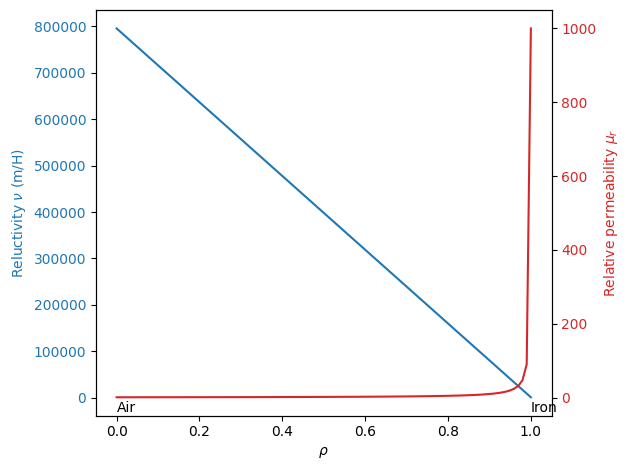

In [6]:
q = 0  # can be changed to add penalization

nu0 = 1/(4e-7*pi)
nu_f = nu0/1000

def rho2nu(rho):
    """ Returns RAMP interpolation of reluctivity
    q = 0  => linear interpolation of reluctivity """
    return  nu0 + (nu_f-nu0)*rho/(q-q*rho+1)  

def dnu_drho(rho):
    """ Derivative of rho2nu """
    return (nu_f-nu0)*(q+1)/(q-q*rho+1)**2
    
######## Plot
import matplotlib.pyplot as plt
import numpy as np

r = np.linspace(0,1,100)
fig, ax1 = plt.subplots(); color = 'tab:blue'
ax1.plot(r,rho2nu(r), color = color); ax1.text(0,-3e4,"Air"); ax1.text(1,-3e4,"Iron")
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xlabel('$\\rho$'); ax1.set_ylabel("Reluctivity $\\nu$ (m/H)", color = color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel("Relative permeability $\\mu_r$", color=color)
ax2.plot(r, nu0/rho2nu(r), color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
plt.show()
########

## 5) Gradient of objective function w.r.t $\rho$

In [7]:
from Solver import Curl

def dobjectiveFunction_drho(rho, state, adjoint):
    return - Curl(adjoint) * (dnu_drho(rho) * Curl(state))

Draw(dobjectiveFunction_drho(0, a0, p0), mesh, settings = {"Objects" : { "Wireframe" : False } })

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fals…

BaseWebGuiScene

## 6) Volume

In [8]:
V0 = Integrate(CF((1)), mesh) # volume of Omega

def volume(rho):
    return Integrate(rho, mesh) / V0

def dvolume_drho(rho):
    """ Scalar field representing the linear form obtained by the directional derivative of the volume 
    The directionnal derivative in the gamma direction reads < dvolume_drho, gamma > """
    return CF((1)) / V0

## 7) Optimization

We use an augmented Lagrange algorithm. We want to find the saddle point of the augmented Lagrangian

$$ \mathcal L(\rho,\lambda) = f(\rho) + \lambda g(\rho) + \frac{\beta}{2} (g(\rho))^2$$

with $f$ the objective function, $\lambda$ a Lagrange multiplier and $g$ an equality constraint. So, $\mathcal L$ should be minimized w.r.t $\rho$ and maximized w.r.t $\lambda$ :

$$ (\rho^*, \lambda^*) = \arg \max_\lambda \min_{\rho} L(\rho,\lambda)  $$

The algorithm is the following loop :
- Inner minimization of $\mathcal L(\rho,\lambda)$ w.r.t $\rho$
- Update of $\lambda$ such that $\lambda \gets \lambda + \beta g(\rho)$ so that $\lambda$ increases

### a) Inner minimization

We use a projected gradient descent with simple step control.

In [9]:
from copy import copy

mask = GridFunction(L2(mesh))
mask.Set(mesh.MaterialCF({"Omega_c" : 1}))
maskOmega_c = mask.vec.FV().NumPy()[:]

def innerMinimization(rho, lam, 
                      step = 0.1, beta = 1e-3,
                      n_max = 50, step_min = 1e-4, 
                      f = objectiveFunction,                                # df_du(u)
                      g = lambda rho : (volume(rho) - 0.1),                 # g(rho)
                      df_du = objectiveFunctionDD,                          # df_du(u, uStar)
                      dg_drho = dvolume_drho,                               # dg_drho(rho)
                      df_drho = dobjectiveFunction_drho,                    # df_drho(rho, u, p)
                      maskOmega_c = maskOmega_c,                            # mask of the optimization domain
                      scene = None):
    n = 0
    mesh = rho.space.mesh
    Lagr = lambda rho, u : f(u) + lam * g(rho) + beta / 2 * (g(rho))**2
    dLagr_drho = lambda rho, u, p : df_drho(rho, u, p) + lam * dg_drho(rho) + beta * g(rho)
    u = solveMag(rho2nu(rho), mesh)[0]
    L_history = [Lagr( rho,u)]
    obj_history = [f(u)]
    g_history = [g(rho)]
    rho_history = [copy(rho)]
    while ( n < n_max and step > step_min):

        n += 1
        if scene is not None : scene.Redraw(rho, min=0, max=1, settings = {"Objects" : { "Wireframe" : False } })
    
        # 1) Magnetic state computation
        u, Kinv = solveMag(rho2nu(rho), mesh)
        
        # 2) Adjoint computation
        p = solveAdjoint(Kinv, u, df_du)
        
        # 3) Gradient computation
        gradient = dLagr_drho(rho, u, p)

        # 4) Update
        rho_test = GridFunction(rho.space)
        rho_test.Set(rho - step * gradient)
        
        # 5) Projection
        rho_test.vec[:].FV().NumPy()[rho_test.vec[:].FV().NumPy()<0] = 0
        rho_test.vec[:].FV().NumPy()[rho_test.vec[:].FV().NumPy()>1] = 1
        rho_test.vec[:].FV().NumPy()[maskOmega_c==0] = 0
        
        # 6) Step control
        u_test, _ = solveMag(rho2nu(rho_test), mesh)
        L_history.append(Lagr(rho_test, u_test))
        g_history.append(g(rho_test))
        obj_history.append(f(u_test))
        
        print(f'it n°{n} | f = {L_history[-1] :.6e} | g = {g_history[-1]  :.3e} | {step = : .3e}                   ', end = '\r')
        
        if L_history[-1] >= L_history[-2]:   # failure
            step *= 0.5
            L_history.pop(); g_history.pop() ; obj_history.pop()
        else :                               # succes
            step *= 1.2
            rho = rho_test
            rho_history.append(copy(rho))
    return rho_history, L_history, obj_history, g_history, step, n 

### b) Optimization parameters

In [10]:
## Initialization
mass_target = 0.1   # Target volume
rho0 = mass_target; # Initial value of rho (homogeneous)
rho = GridFunction(L2(mesh))
rho.Set(mesh.MaterialCF({ "Omega_c" : rho0}, default=0))

beta = 0.01         # Penalization coefficient
lam = 0              # Initial value of Lagrange multiplier

step = 10          # Initial step
step_min = 1e-4     # Minimal step 
N_outer_max = 10     # Maximal number of outer iteration (maximization)
N_inner_max = 2     # Maximal number of inner iteration (minimization)

N_outer = 0
N_endInner = [0]
N_iter_tot = 0
Lagr_OuterList, g_OuterList, f_OuterList = [], [], []
lamList = [lam]
rho_OuterList = [rho]
stepList = [step]

### c) Optimization loop

In [11]:
scene = Draw(rho, min=0, max=1, settings = {"Objects" : { "Wireframe" : False } })

g  = lambda rho : (volume(rho) - 0.1)

for N_outer in range(N_outer_max) :

    print(f"\n{N_outer = }")

    rho_history, L_history, obj_history, g_history, step, N_inner = innerMinimization(rho, lam,
                                                           step = step, 
                                                           beta = beta,
                                                           g = g,
                                                           n_max = N_inner_max, 
                                                           step_min = step_min, 
                                                           scene = scene)
    
    rho = rho_history[-1]
    rho_OuterList.append(copy(rho))
    Lagr_OuterList.append(L_history[-1])
    g_OuterList.append(g_history[-1])
    f_OuterList.append(obj_history[-1])
    N_iter_tot += N_inner
    N_endInner.append(N_iter_tot)
    stepList.append(step)
    step *= 2
    # update Lagrange multiplier
    lam += beta * g(rho)
    lamList.append(lam)
    
    

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fals…


N_outer = 0
it n°2 | f = -4.408828e-06 | g = -1.006e-04 | step =  1.200e+01                   
N_outer = 1
it n°2 | f = -4.910227e-06 | g = 8.333e-04 | step =  3.456e+01                   
N_outer = 2
it n°2 | f = -7.843991e-06 | g = 7.531e-04 | step =  9.953e+01                    
N_outer = 3
it n°2 | f = -2.339833e-04 | g = 1.980e-02 | step =  2.867e+02                    
N_outer = 4
it n°2 | f = -2.649064e-02 | g = 7.108e-04 | step =  8.256e+02                   
N_outer = 5
it n°2 | f = -2.683810e-02 | g = 1.119e-03 | step =  2.378e+03                   
N_outer = 6
it n°2 | f = -2.687943e-02 | g = 1.426e-03 | step =  6.848e+03                   
N_outer = 7
it n°2 | f = -2.689814e-02 | g = 1.591e-03 | step =  1.972e+04                   
N_outer = 8
it n°2 | f = -2.689812e-02 | g = 1.591e-03 | step =  2.367e+04                   
N_outer = 9
it n°2 | f = -2.689809e-02 | g = 1.591e-03 | step =  6.816e+04                   

## 8) Analysis of the results

### a) Quantities of interest

In [12]:
u, _ = solveMag(rho2nu(rho),mesh)
print(f"Results Density (mu) : flux = {avgSecondaryFlux(u) : .5e} | vol = {volume(rho)*100 : .3f} % | iterations = {N_iter_tot}")

Results Density (mu) : flux =  2.68985e-05 | vol =  10.159 % | iterations = 20


### b) Evolution of the objective function and constraint

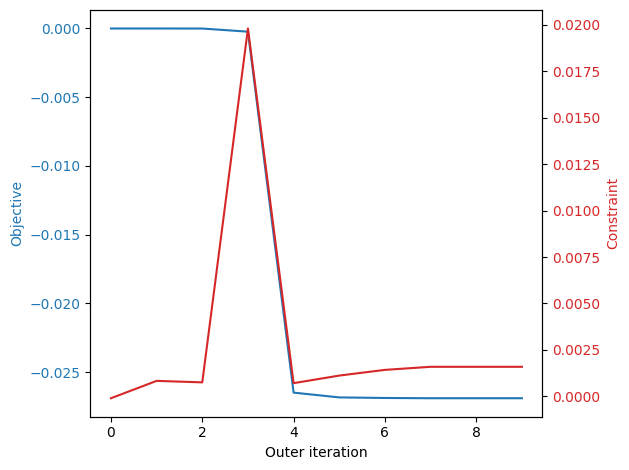

In [13]:
fig, ax1 = plt.subplots(); color = 'tab:blue'
ax1.plot(f_OuterList, color = color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xlabel('Outer iteration'); ax1.set_ylabel("Objective", color = color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel("Constraint", color=color)
ax2.plot(g_OuterList, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
plt.show()

### b) Evolution of lambda and step

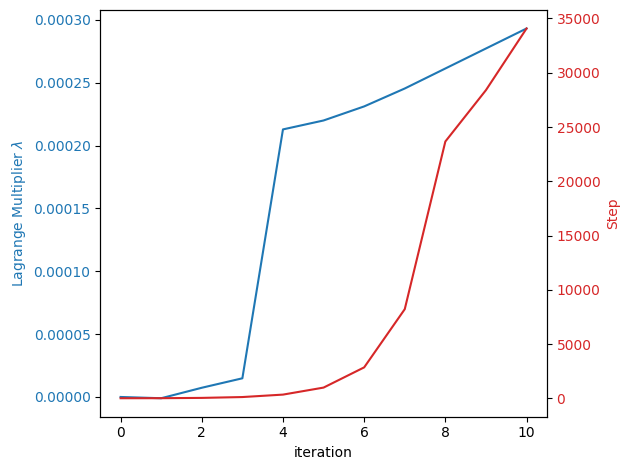

In [14]:
fig, ax1 = plt.subplots(); color = 'tab:blue'
ax1.plot(lamList, color = color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xlabel('iteration'); ax1.set_ylabel("Lagrange Multiplier $\lambda$", color = color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel("Step", color=color)
ax2.plot(stepList, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
plt.show()